# Docling Lab 3: Advanced RAG with Multimodal Support & Visual Grounding

*Using IBM Granite vision, text-based embeddings and generative AI models*

This lab represents the culmination of everything you've learned, showing how Docling enables not just document processing, but truly transparent AI systems.

## Why This Lab Matters

Traditional RAG systems have a trust problem. When an AI provides information, users often wonder:
- "Where did this information come from?"
- "Can I verify this is accurate?"
- "Is the AI hallucinating or using real data?"

**Visual grounding solves this problem** by showing users exactly where information was retrieved from in the original documents. This isn't just a nice-to-have feature - it's essential for:
-  **Healthcare**: Verify medical information sources
-  **Legal**: Trace citations to exact document locations
-  **Financial**: Audit AI-generated financial insights
-  **Research**: Validate scientific claims
-  **Enterprise**: Build trustworthy internal AI systems

## What Makes This Lab Special

We're not just building another RAG system. We're creating a **multimodal RAG system with visual grounding** that:

1. **Processes Multiple Data Types**: Text, tables, and images from your documents
2. **Shows Exact Sources**: Highlights the precise location of retrieved information
3. **Understands Images**: Uses AI vision models to comprehend visual content
4. **Maintains Transparency**: Every answer can be visually verified


---


## Understanding Multimodal RAG with Visual Grounding


### What is Multimodal RAG?

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) is a technique used with large language models (LLMs) to connect the model with a knowledge base of information outside the data the LLM has been trained on without having to perform [fine-tuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning). Traditional RAG is limited to text-based use cases such as text summarization and chatbots.

Traditional RAG systems only handle text. But real documents contain:
- **Text**: Paragraphs, lists, headers
- **Tables**: Structured data, financial information
- **Images**: Charts, diagrams, photos, illustrations

Multimodal RAG can use [multimodal LLMs](https://www.ibm.com/think/topics/multimodal-ai) (MLLM) to process information from multiple types of data to be included as part of the external knowledge base used in RAG. Multimodal data can include text, images, audio, video or other forms.


### Visual Grounding: The Transparency Layer

Visual grounding adds a crucial transparency layer to RAG systems. When the system retrieves information to answer a query, it doesn't just return text - it shows you exactly where in the original document that information came from by:
- Drawing bounding boxes on document pages
- Highlighting specific regions
- Labeling content types (TEXT, TABLE, IMAGE)
- Using different colors for multiple sources

For this recipe, you will use IBM Granite models capable of processing different modalities, enhanced with Docling's visual grounding capabilities to create a transparent, verifiable AI system.

---


## Recipe Overview

In this comprehensive lab, you'll learn how to:

1. **Configure Docling for Visual Grounding**: Set up document processing to maintain visual references
2. **Process Multimodal Content**: Handle text, tables, and images with proper metadata
3. **Leverage AI Vision Models**: Use IBM Granite vision models to understand images
4. **Build a Vector Database**: Store embeddings with visual grounding metadata
5. **Implement Visual Attribution**: Show users exactly where information comes from
6. **Create a Complete RAG Pipeline**: Combine all components into a production-ready system

### Technologies We'll Use

Building on our previous labs, we'll add:

1. **[Docling](https://docling-project.github.io/docling/):** An open-source toolkit used to parse and convert documents.
2. **[LangChain](https://langchain.com)**: For orchestrating the RAG pipeline
3. **[IBM Granite Vision Models](https://www.ibm.com/granite/)**: For understanding image content
4. **Visual Grounding**: Docling's unique capability for source attribution


---

## Prerequisites

Before we begin, ensure you have:
- Basic understanding of embeddings and vector databases
- Familiarity with the concepts from previous labs

## Install Dependencies

Now let's install all necessary packages. Note that we're building on the packages from previous labs and adding vision and RAG-specific components:

## Import Required Libraries and Configure Logging


In [18]:
! uv pip install -q \
    docling \
    transformers \
    pillow \
    langchain_community \
    langchain_huggingface \
    langchain_milvus \
    pymilvus[milvus_lite] \
    langchain-openai\
    sentence-transformers \
    matplotlib \
    "git+https://github.com/ibm-granite-community/utils.git"

I0000 00:00:1758641832.894632  851216 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Logging Configuration

To see detailed information about the document processing and visual grounding operations, we'll configure INFO log level.

NOTE: It is okay to skip running this cell if you prefer less verbose output.

In [19]:
import logging

logging.basicConfig(level=logging.WARNING)

### Required Libraries

Now let's import all necessary modules, organized by their purpose:


In [20]:
# import itertools
import tempfile
from pathlib import Path
from tempfile import mkdtemp

import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageOps
from PIL import ImageDraw
from IPython.display import display

# Docling imports for document processing and visual grounding
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.datamodel.document import DoclingDocument
# from docling.chunking import DocMeta
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import RefItem
from docling.datamodel.pipeline_options import PictureDescriptionApiOptions

# LangChain imports for RAG pipeline
from langchain_huggingface import HuggingFaceEmbeddings

from langchain_core.documents import Document
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus
from langchain.prompts import PromptTemplate
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

# Model imports
from transformers import AutoTokenizer
from ibm_granite_community.notebook_utils import escape_f_string


---

## Selecting and loading the AI models

### The Three Pillars of Multimodal RAG

For a complete multimodal RAG system with visual grounding, we need three types of models, each serving a crucial purpose:

1. **Embedding Model**: Converts text into vector representations
   - Enables semantic search ("find content similar in meaning")
   - Must handle text from chunks, tables, and image descriptions

2. **Vision Model**: Understands and describes visual content
   - Processes images found in documents
   - Generates textual descriptions for retrieval

3. **Language Model**: Generates final responses
   - Synthesizes retrieved information
   - Produces coherent, accurate answers

### Load the Granite Embedding Model

We'll use the [Granite Embedding model](https://huggingface.co/collections/ibm-granite/granite-embedding-models-6750b30c802c1926a35550bb) for generating text embedding vectors.

In [21]:
embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
embeddings_model = HuggingFaceEmbeddings(
    model_name=embeddings_model_path,
)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)
print(f"Embeddings model loaded: {embeddings_model_path}")

Embeddings model loaded: ibm-granite/granite-embedding-30m-english


#### Why this model

- Optimized for English text
- Compact (30M parameters) for fast processing
- Excellent semantic understanding
- 512 token context window

To use a different embeddings model, you can refer to [this Embeddings Model recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Embeddings_Models.ipynb).

### Load the Granite Vision Model

The vision model will help us understand images within documents. This is crucial for truly multimodal RAG as many documents contain important visual information.

The relevant configuration is specified in the pipeline options further below.

For more details on using vision models check out the docs [here]( https://docling-project.github.io/docling/usage/enrichments/#picture-description). 

<!--
# vision_model_path = "ibm-granite/granite-vision-3.2-2b"
# vision_model = Replicate(
#     model=vision_model_path,
#     replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
#     model_kwargs={
#         "max_tokens": embeddings_tokenizer.max_len_single_sentence,
#         "min_tokens": 100,
#         "temperature": 0.01 # low temperature for reproduceability
#     },
# )
# vision_processor = AutoProcessor.from_pretrained(vision_model_path)
# print(f"Vision model loaded: {vision_model_path}")
-->

### Load the Granite Language Model

Finally, our language model will generate responses based on retrieved context.

**Why this model**:
- 8B parameters: Good balance of quality and speed
- Instruction-tuned: Follows prompts accurately
- Granite family: Open-source and Apache 2.0 licensed

In [22]:
model_path = "ibm-granite/granite-3.3-8b-instruct"
from langchain_openai import ChatOpenAI
model = ChatOpenAI(
    model_name=model_path,
    api_key="none",
    base_url="http://localhost:1234/v1",  # OpenAI-compatible API, e.g. local LM Studio
    temperature=0.01,
)

tokenizer = AutoTokenizer.from_pretrained(model_path)
print(f"Language model loaded: {model_path}")

Language model loaded: ibm-granite/granite-3.3-8b-instruct



---


## Enhanced document processing with visual grounding support

### The Foundation of Visual Grounding

Visual grounding requires special configuration during document conversion. Unlike standard processing, we need to:

1. **Generate high-quality page images**: For displaying visual highlights
2. **Preserve coordinate information**: To know where content is located
3. **Maintain document structure**: For accurate source attribution
4. **Store documents properly**: For later retrieval and visualization

Let's configure Docling with these requirements:


In [23]:
# Configure converter with visual grounding capabilities
pdf_pipeline_options = PdfPipelineOptions(
    generate_picture_images=True,  # Extract images from documents
    generate_page_images=True,  # CRITICAL: Generate page images for visual grounding
    do_picture_description=True,
    enable_remote_services = True,
    picture_description_options=PictureDescriptionApiOptions(
        url="http://localhost:1234/v1/chat/completions",
        params={
            "model": "granite-vision-3.3-2b",#"granite-vision", #"replicate/ibm-granite/granite-vision-3.3-2b",
            "max_tokens": embeddings_tokenizer.max_len_single_sentence,
            "min_tokens": 100,
            "temperature": 0.01 # low temperature for reproduceability
        },
        prompt="Give a detailed description of what is depicted in the image",
        timeout=60,
        concurrency=4,
        picture_area_threshold=0.1,
        # headers={
        #     "Authorization": "Bearer abc",
        # }
    ),
    images_scale=2.0,
)

format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}

converter = DocumentConverter(format_options=format_options)
print("Document converter configured with visual grounding support and picture description")

Document converter configured with visual grounding support and picture description


### Create a Document Store for Visual Grounding

The document store will maintain the full document structure needed for visual grounding. This is essential for highlighting source locations later:

In [24]:
# Create document store for visual grounding
doc_store = {}
doc_store_root = Path(mkdtemp())
print(f"Document store created at: {doc_store_root}")

Document store created at: /var/folders/76/4wwfs06x6835kcwj4186c0nc0000gn/T/tmpe61ikjej


### Convert Documents with Visual Tracking

Now let's process documents while preserving all information needed for visual grounding:


In [25]:
sources = [
    "https://arxiv.org/pdf/2206.01062",
    "https://arxiv.org/pdf/2311.18481",
    # Add more document URLs here as needed
]

conversions = {}

print("Starting document conversion with visual grounding support...")
for source in sources:
    print(f"\n Processing: {source}")

    # Convert document
    result = converter.convert(source=source)
    docling_document = result.document
    conversions[source] = docling_document

    # Save document to store for visual grounding
    # The binary hash ensures unique identification
    file_path = doc_store_root / f"{docling_document.origin.binary_hash}.json"
    docling_document.save_as_json(file_path)
    doc_store[docling_document.origin.binary_hash] = file_path

    print(f"Document converted and saved")
    print(f"  - Document ID: {docling_document.origin.binary_hash}")
    print(f"  - Pages: {len(docling_document.pages)}")
    print(f"  - Tables: {len(docling_document.tables)}")
    print(f"  - Images: {len(docling_document.pictures)}")

Starting document conversion with visual grounding support...

 Processing: https://arxiv.org/pdf/2206.01062
Document converted and saved
  - Document ID: 7156212269791437020
  - Pages: 9
  - Tables: 5
  - Images: 6

 Processing: https://arxiv.org/pdf/2311.18481
Document converted and saved
  - Document ID: 13823681836276983029
  - Pages: 3
  - Tables: 1
  - Images: 1


## Process Document Content with Visual Grounding Metadata


### The Importance of Metadata Preservation

For visual grounding to work, every chunk of content must maintain metadata about its source location. This includes:
- **Page numbers**: Which page(s) contain this content
- **Bounding boxes**: Exact coordinates on the page
- **Document references**: Links back to the source document
- **Content type**: Whether it's text, table, or image

This metadata is what enables us to draw accurate highlights on document pages later.


### Process Text Chunks with Location Tracking


Next we process any tables in the documents. We convert the table data to markdown format for passing into the language model. A list of LangChain documents are created from the table's markdown renderings.

In [26]:
from docling.chunking import DocMeta
from docling_core.transforms.chunker.hierarchical_chunker import (
    ChunkingDocSerializer,
    ChunkingSerializerProvider,
)
from docling_core.transforms.serializer.markdown import MarkdownTableSerializer

class MDTableSerializerProvider(ChunkingSerializerProvider):
    def get_serializer(self, doc):
        return ChunkingDocSerializer(
            doc=doc,
            table_serializer=MarkdownTableSerializer(),  # configuring a different table serializer
        )

doc_id = 0
chunks: list[Document] = []
num_text_chunks = 0
num_table_chunks = 0
num_picture_chunks = 0

print("\nProcessing text chunks with visual grounding metadata...")
for source, docling_document in conversions.items():
    chunker = HybridChunker(
        tokenizer=embeddings_tokenizer,
        serializer_provider=MDTableSerializerProvider(),
    )

    for chunk in chunker.chunk(docling_document):
        items = chunk.meta.doc_items

        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        item_type = ""
        picture_ref = ""
        if "#/pictures" in refs:
            num_picture_chunks += 1
            item_type = "picture"
            picture_ref = [item.get_ref().cref for item in items if "#/pictures/" in item.get_ref().cref][0]
        elif "#/tables" in refs:
            num_table_chunks += 1
            item_type = "table"
        else:
            num_text_chunks += 1
            item_type = "text"
        text = chunker.contextualize(chunk=chunk)

        # Create document with enhanced metadata for visual grounding
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": refs,  # References for tracking specific document items
                "dl_meta": chunk.meta.model_dump(),  # CRITICAL: Store chunk metadata for visual grounding
                "item_type": item_type,
                "picture_ref": picture_ref,
                "origin_hash": docling_document.origin.binary_hash  # Link to stored document
            },
        )
        chunks.append(document)

print(f"Created {len(chunks)} chunks with visual grounding metadata")
print(f"  {num_text_chunks} text-only chunks.")
print(f"  {num_table_chunks} table chunks.")
print(f"  {num_picture_chunks} picture chunks.")


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors



Processing text chunks with visual grounding metadata...
Created 68 chunks with visual grounding metadata
  35 text-only chunks.
  25 table chunks.
  8 picture chunks.


### Process Images with Vision Understanding

For true multimodal RAG, we need to understand the content of images. We'll use the Granite vision model to generate descriptions.


NOTE: Processing images can take time depending on the number of images and the vision model service. Each image will be analyzed individually.

### Display Sample Processed Documents

Let's examine what we've created to understand the multimodal nature of our system:


Sample processed documents:

TEXT CHUNK EXAMPLES:
--------------------------------------------------------------------------------

Text Chunk 1:
  Document ID: 1
  Source: 2206.01062
  Reference: #/texts/2 #/texts/3 #/texts/4 #/texts/5 #/texts/6 #/texts/7 #/texts/8
  Has visual grounding: True
  Content preview:
    DocLayNet: A Large Human-Annotated Dataset for Document-Layout Analysis
Birgit Pfitzmann IBM Research Rueschlikon, Switzerland bpf@zurich.ibm.com
Christoph Auer IBM Research Rueschlikon, Switzerland cau@zurich.ibm.com
Ahmed S. Nassar IBM Research
Rue...
----------------------------------------

Text Chunk 2:
  Document ID: 4
  Source: 2206.01062
  Reference: #/texts/313
  Has visual grounding: True
  Content preview:
    KEYWORDS
PDF document conversion, layout segmentation, object-detection, data set, Machine Learning...
----------------------------------------

Text Chunk 3:
  Document ID: 5
  Source: 2206.01062
  Reference: #/texts/315
  Has visual grounding: True
  Co

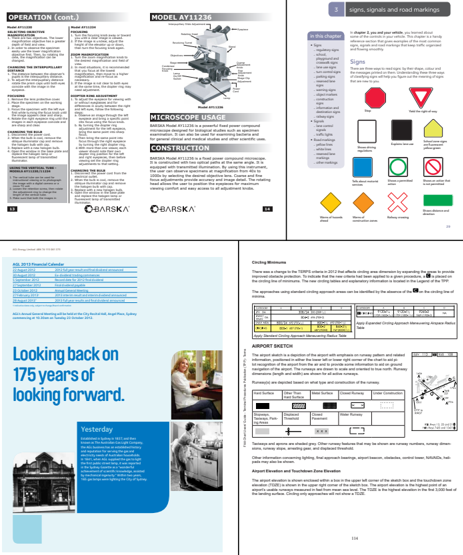

----------------------------------------

Image 2:
  Document ID: 3
  Reference: #/pictures/0
  AI-Generated Description:
    DocLayNet: A Large Human-Annotated Dataset for Document-Layout
    Analysis ### Analysis: The image appears to be a user manual or
    instructional guide for a piece of equipment, possibly related to
    aviation given the presence of airport-related

  Original Image:


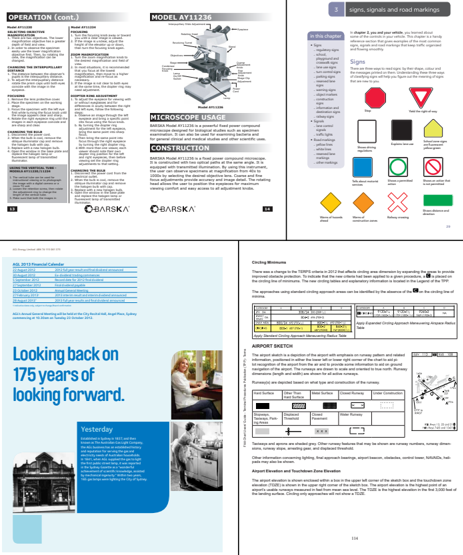

----------------------------------------

Image 3:
  Document ID: 27
  Reference: #/tables/0 #/texts/372 #/pictures/2 #/texts/396
  AI-Generated Description:
    4 ANNOTATION CAMPAIGN | Total          | 1107470 | 941123       |
    99816        | 66531        | 82-83
    | 71-74                                      | 79-81
    | 89-94                                      | 86-91
    | 71-76                                      | 68-85
    | Figure 3: Corpus Conversion Service annotation user interface.
    The PDF page is shown in the background, with overlaid text-cells
    (in darker shades). The annotation boxes can be drawn by dragging
    a rectangle over each segment with the respective label from the
    palette on the right.  The image appears to be a screenshot from a
    software interface that is used for creating or editing documents.
    It shows a document with various elements such as text, images,
    and charts. The interface includes options for selecting fields,
    

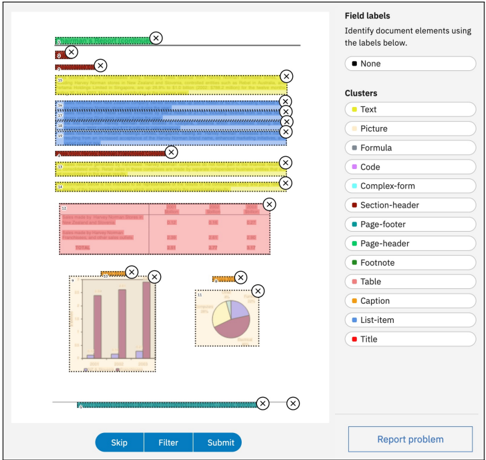

----------------------------------------


In [27]:
print("\nSample processed documents:")
print("=" * 80)

# Show sample text chunks
print("\nTEXT CHUNK EXAMPLES:")
print("-" * 80)
c = 0
for chunk in chunks:  # Show first 3 text chunks
    if chunk.metadata["item_type"] != "text":
        continue
    c += 1
    print(f"\nText Chunk {c}:")
    print(f"  Document ID: {chunk.metadata['doc_id']}")
    print(f"  Source: {chunk.metadata['source'].split('/')[-1]}")  # Just filename
    print(f"  Reference: {chunk.metadata['ref']}")
    print(f"  Has visual grounding: {'dl_meta' in chunk.metadata}")
    print(f"  Content preview:")
    print(f"    {chunk.page_content[:250]}...")
    print("-" * 40)
    if c >= 3:
        break

# Show sample tables
print("\n\nTABLE EXAMPLES:")
print("-" * 80)
c = 0
for chunk in chunks:  # Show first 3 tables
    if chunk.metadata["item_type"] != "table":
        continue
    c += 1
    print(f"\nTable {c}:")
    print(f"  Document ID: {chunk.metadata['doc_id']}")
    print(f"  Reference: {chunk.metadata['ref']}")
    print(f"  Content preview (Markdown format):")
    # Show first few lines of the table
    table_lines = chunk.page_content.split('\n')[:8]
    for line in table_lines:
        print(f"    {line}")
    print("-" * 40)
    if c >= 3:
        break

# Show sample images with descriptions
print("\n\nIMAGE EXAMPLES WITH AI-GENERATED DESCRIPTIONS:")
print("-" * 80)
c = 0
for chunk in chunks:  # Show first 3 images
    if chunk.metadata["item_type"] != "picture":
        continue
    c += 1
    print(f"\nImage {c}:")
    print(f"  Document ID: {chunk.metadata['doc_id']}")
    print(f"  Reference: {chunk.metadata['ref']}")
    print(f"  AI-Generated Description:")
    # Wrap the description for better readability
    import textwrap
    wrapped_text = textwrap.fill(chunk.page_content, width=70, initial_indent="    ", subsequent_indent="    ")
    print(wrapped_text)

    # Display the actual image
    source = chunk.metadata['source']
    ref = chunk.metadata['picture_ref']
    docling_document = conversions[source]
    picture = RefItem(cref=ref).resolve(docling_document)
    image = picture.get_image(docling_document)
    if image:
        print(f"\n  Original Image:")
        # Resize image for display if too large
        display_image = image.copy()
        max_width = 600
        if display_image.width > max_width:
            ratio = max_width / display_image.width
            new_height = int(display_image.height * ratio)
            display_image = display_image.resize((max_width, new_height), PIL.Image.Resampling.LANCZOS)
        display(display_image)

    print("-" * 40)
    if c >= 3:
        break


## Visual Grounding Functions

### Understanding Visual Source Attribution

Visual grounding is what sets this system apart. These functions enable us to:
1. **Locate**: Find the exact source of any retrieved information
2. **Highlight**: Draw visual indicators on document pages
3. **Differentiate**: Use different styles for text, tables, and images
4. **Verify**: Allow users to confirm AI responses against source documents


### Implementing the Core Visual Grounding Function

In [28]:
def visualize_chunk_grounding(chunk, doc_store, highlight_color="blue"):
    """
    Visualize where a text chunk comes from in the original document.

    This function:
    1. Loads the original document from the store
    2. Finds the pages containing the chunk content
    3. Draws bounding boxes around the source regions
    4. Displays the highlighted pages

    Args:
        chunk: LangChain Document with visual grounding metadata
        doc_store: Dictionary mapping document hashes to file paths
        highlight_color: Color for highlighting (blue, green, red, etc.)

    Returns:
        Dictionary of page images with highlights
    """
    # Get the origin hash
    origin_hash = chunk.metadata.get("origin_hash")
    if not origin_hash:
        print("No origin hash found in metadata")
        return None

    # Load the full document from store
    dl_doc = DoclingDocument.load_from_json(doc_store.get(origin_hash))

    print(f"Visualizing source location for chunk {chunk.metadata.get('doc_id', 'Unknown')}")

    # Handle different types of content
    page_images = {}
    item_type = chunk.metadata.get("item_type", "text")

    if item_type in ["picture", "table"] and "prov_data" in chunk.metadata:
        # Handle tables and pictures with simple provenance data
        prov_data = chunk.metadata["prov_data"]

        if not prov_data:
            print(f"No provenance data available for this {item_type}")
            return None

        for prov in prov_data:
            page_no = prov["page_no"]

            # Get page image
            if page_no < len(dl_doc.pages):
                page = dl_doc.pages[page_no]
                if hasattr(page, 'image') and page.image:
                    if page_no not in page_images:
                        img = page.image.pil_image.copy()
                        page_images[page_no] = {
                            'image': img,
                            'page': page,
                            'draw': ImageDraw.Draw(img)
                        }

                    # Draw bounding box
                    draw = page_images[page_no]['draw']
                    bbox = prov["bbox"]

                    # Draw bounding box
                    draw = page_images[page_no]['draw']
                    bbox = prov["bbox"]

                    # The coordinates are already normalized and in top-left origin
                    # Just scale to image dimensions
                    img_width = page_images[page_no]['image'].width
                    img_height = page_images[page_no]['image'].height

                    l = int(bbox["l"] * img_width)
                    r = int(bbox["r"] * img_width)
                    t = int(bbox["t"] * img_height)
                    b = int(bbox["b"] * img_height)

                    # Ensure coordinates are valid (min/max) just in case
                    l, r = min(l, r), max(l, r)
                    t, b = min(t, b), max(t, b)

                    # Clamp to image bounds
                    l = max(0, min(l, img_width - 1))
                    r = max(0, min(r, img_width - 1))
                    t = max(0, min(t, img_height - 1))
                    b = max(0, min(b, img_height - 1))

                    # Draw highlight with different styles for different types
                    if item_type == "picture":
                        draw.rectangle([l, t, r, b], outline=highlight_color, width=4)
                        draw.text((l, t-20), "IMAGE", fill=highlight_color)
                    elif item_type == "table":
                        draw.rectangle([l, t, r, b], outline=highlight_color, width=3)
                        draw.text((l, t-20), "TABLE", fill=highlight_color)

    elif "dl_meta" in chunk.metadata:
        # Handle text chunks with DocMeta
        try:
            meta = DocMeta.model_validate(chunk.metadata["dl_meta"])

            # Process each item in the chunk to find source locations
            for doc_item in meta.doc_items:
                if hasattr(doc_item, 'prov') and doc_item.prov:
                    for prov in doc_item.prov:
                        page_no = prov.page_no

                        # Get or create page image
                        if page_no not in page_images:
                            if page_no < len(dl_doc.pages):
                                page = dl_doc.pages[page_no]
                                if hasattr(page, 'image') and page.image:
                                    img = page.image.pil_image.copy()
                                    page_images[page_no] = {
                                        'image': img,
                                        'page': page,
                                        'draw': ImageDraw.Draw(img)
                                    }

                        # Draw bounding box on the page
                        if page_no in page_images:
                            page_data = page_images[page_no]
                            page = page_data['page']
                            draw = page_data['draw']

                            # Convert coordinates to image space
                            bbox = prov.bbox.to_top_left_origin(page_height=page.size.height)
                            bbox = bbox.normalized(page.size)

                            # Scale to actual image dimensions
                            l = int(bbox.l * page_data['image'].width)
                            r = int(bbox.r * page_data['image'].width)
                            t = int(bbox.t * page_data['image'].height)
                            b = int(bbox.b * page_data['image'].height)

                            # Draw highlight rectangle
                            draw.rectangle([l, t, r, b], outline=highlight_color, width=2)
        except Exception as e:
            print(f"Error processing text chunk metadata: {e}")
            return None
    else:
        print("No visual grounding metadata available for this chunk")
        return None

    # Display highlighted pages
    for page_no, page_data in sorted(page_images.items()):
        plt.figure(figsize=(12, 16))
        plt.imshow(page_data['image'])
        plt.axis('off')

        # Add title indicating content type
        if item_type == "picture":
            title = "Image Location"
        elif item_type == "table":
            title = "Table Location"
        else:
            title = "Text Location"
        plt.title(f'{title} - Page {page_no + 1}', fontsize=16)
        plt.tight_layout()
        plt.show()

    return page_images


## Populate the Vector Database

### Understanding Vector Databases in Multimodal RAG

Vector databases are the search engine of our RAG system. They:
- Store numerical representations (embeddings) of our content
- Enable semantic similarity search
- Maintain all metadata needed for visual grounding
- Support fast retrieval at scale

For multimodal content, this means:
- Text chunks are embedded directly
- Table markdown is embedded for structure search
- AI-generated image descriptions are embedded for visual search


### Choose and Configure Vector Database

We'll use Milvus, a high-performance vector database. For other vector database options, see [this Vector Store recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Vector_Stores.ipynb).

In [32]:
# Create a temporary database file
db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"Vector database will be saved to: {db_file}")

# Initialize Milvus vector store
vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,  # Allows flexible metadata storage
    index_params={"index_type": "AUTOINDEX"},  # Automatic index optimization
)


Vector database will be saved to: /var/folders/76/4wwfs06x6835kcwj4186c0nc0000gn/T/vectorstore_g413dwv0.db


I0000 00:00:1758642161.868167  851216 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Add Documents to Vector Database

Now we'll add all our processed documents (text chunks, tables, and image descriptions) to the vector database:

In [33]:
print("\nAdding documents to vector database...")
documents = chunks
ids = vector_db.add_documents(documents)
print(f"Successfully added {len(ids)} documents to the vector database")


Adding documents to vector database...
Successfully added 68 documents to the vector database


## Test Retrieval with Visual Grounding

### Understanding Retrieval Testing

Before building the full RAG pipeline, let's test that our retrieval and visual grounding work correctly. This helps verify:
- Content is being found based on semantic similarity
- Visual grounding metadata is preserved
- Different content types are handled properly

### Basic Retrieval Test


In [34]:
# Test query
query = "How many PDF pages does DocLayNet contain?"

print(f"\nTesting retrieval for query: '{query}'")
print("=" * 80)

# Retrieve relevant documents
retrieved_docs = vector_db.as_retriever().invoke(query)

# Display retrieved documents
for i, doc in enumerate(retrieved_docs):
    print(f"\nRetrieved Document {i+1}:")

    # Determine content type
    item_type = doc.metadata.get('item_type', 'text')
    if item_type == 'picture':
        content_type = "AI-Generated Image Description"
    elif item_type == 'table':
        content_type = "Table (Markdown)"
    else:
        content_type = "Text Chunk"

    print(f"Type: {content_type}")
    print(f"Content preview: {doc.page_content[:200]}...")
    print(f"Source: {doc.metadata['source'].split('/')[-1]}")


Testing retrieval for query: 'How many PDF pages does DocLayNet contain?'

Retrieved Document 1:
Type: Text Chunk
Content preview: 3 THE DOCLAYNET DATASET
DocLayNet contains 80863 PDF pages. Among these, 7059 carry two instances of human annotations, and 1591 carry three. This amounts to 91104 total annotation instances. The anno...
Source: 2206.01062

Retrieved Document 2:
Type: Text Chunk
Content preview: 3 THE DOCLAYNET DATASET
We did not control the document selection with regard to language. The vast majority of documents contained in DocLayNet (close to 95%) are published in English language. Howev...
Source: 2206.01062

Retrieved Document 3:
Type: AI-Generated Image Description
Content preview: DocLayNet: A Large Human-Annotated Dataset for Document-Layout Analysis
Figure 1: Four examples of complex page layouts across different document categories

The image appears to be a page from a tech...
Source: 2206.01062

Retrieved Document 4:
Type: Text Chunk
Content preview: ABSTRACT

## Enhanced RAG with Visual Grounding - Bringing It All Together


### The Complete Multimodal RAG Pipeline

Now we'll implement the full RAG system that:
1. Retrieves relevant multimodal content
2. Shows exactly where each piece comes from
3. Generates accurate, grounded responses

### Understanding Visual Grounding for Different Content Types

Our system handles three content types distinctly:

1. **Text Chunks**: Standard highlighting shows text passages
2. **Tables**: Thick borders with "TABLE" labels mark structured data
3. **Images**: Distinctive borders with "IMAGE" labels show picture locations

This visual differentiation helps users quickly understand what type of content contributed to the AI's response.

### Implementing the Complete RAG Pipeline

In [35]:
def rag_with_visual_grounding(question, vector_db, doc_store, model, tokenizer, top_k=3):
    """
    Perform RAG with visual grounding of results.

    This function:
    1. Retrieves relevant chunks from the vector database
    2. Visualizes where each chunk comes from in the original document
    3. Generates a response using the retrieved context

    Args:
        question: User's query
        vector_db: Vector database with embedded documents
        doc_store: Document store for visual grounding
        model: Language model for response generation
        tokenizer: Tokenizer for the language model
        top_k: Number of chunks to retrieve

    Returns:
        Tuple of (outputs, relevant_chunks)
    """
    print(f"\nQuestion: {question}")
    print("=" * 80)

    # Step 1: Retrieve relevant chunks
    retriever = vector_db.as_retriever(search_kwargs={"k": top_k})
    relevant_chunks = retriever.invoke(question)

    # Step 2: Create RAG pipeline for response generation

    # Create Granite prompt template
    prompt = tokenizer.apply_chat_template(
        conversation=[{
            "role": "user",
            "content": "{input}",
        }],
        documents=[{
            "doc_id": "0",
            "text": "{context}",
        }],
        add_generation_prompt=True,
        tokenize=False,
    )

    prompt_template = PromptTemplate.from_template(
        template=escape_f_string(prompt, "input", "context")
    )

    # Document prompt template
    document_prompt_template = PromptTemplate.from_template(template="""\
<|end_of_text|>
<|start_of_role|>document {{"document_id": "{doc_id}"}}<|end_of_role|>
{page_content}""")

    # Create chains
    combine_docs_chain = create_stuff_documents_chain(
        llm=model,
        prompt=prompt_template,
        document_prompt=document_prompt_template,
        document_separator="",
    )

    rag_chain = create_retrieval_chain(
        retriever=retriever,
        combine_docs_chain=combine_docs_chain,
    )

    # Generate response
    outputs = rag_chain.invoke({"input": question})

    print("\nGenerated Answer:")
    print("=" * 80)
    print(outputs['answer'])
    print("=" * 80)

    # Visualize retrieved chunks and their source locations
    print(f"\nFound {len(relevant_chunks)} relevant chunks:")

    for i, chunk in enumerate(relevant_chunks):
        print(f"\n--- Result {i+1} ---")

        # Determine content type
        item_type = chunk.metadata.get('item_type', 'text')
        if item_type == 'picture':
            content_type = "AI-Generated Image Description"
            color = 'red'
        elif item_type == 'table':
            content_type = "Table (Markdown)"
            color = 'green'
        else:
            content_type = "Text Chunk"
            color = 'blue'

        print(f"Content type: {content_type}")
        print(f"Text preview: {chunk.page_content[:500]}...")
        print(f"Source: {chunk.metadata.get('source', 'Unknown').split('/')[-1]}")

        # Show visual grounding if available
        if "dl_meta" in chunk.metadata or "prov_data" in chunk.metadata:
            visualize_chunk_grounding(
                chunk,
                doc_store,
                highlight_color=color
            )
        else:
            print("  (No visual grounding available for this chunk)")


    return outputs, relevant_chunks

## Demonstrate the Complete System

### Visual Grounding

Let's run our main query and see the complete system in action:


Question: How many PDF pages does DocLayNet contain?

Generated Answer:
DocLayNet contains 80,863 PDF pages <|start_of_cite|>{"document_id": "0"}<|end_of_cite|>.

<|start_of_plugin|>{"id": "citation"}
11: "3 THE DOCLAYNET DATASET
DocLayNet contains 80863 PDF pages. Among these, 7059 carry two instances of human annotations, and 1591 carry three. This amounts to 91104 total annotation instances. The annotations provide layout information in the shape of labeled, rectangular boundingboxes."
<|end_of_plugin|>


Found 2 relevant chunks:

--- Result 1 ---
Content type: Text Chunk
Text preview: 3 THE DOCLAYNET DATASET
DocLayNet contains 80863 PDF pages. Among these, 7059 carry two instances of human annotations, and 1591 carry three. This amounts to 91104 total annotation instances. The annotations provide layout information in the shape of labeled, rectangular boundingboxes. We define 11 distinct labels for layout features, namely Caption , Footnote , Formula , List-item , Page-footer , Pa

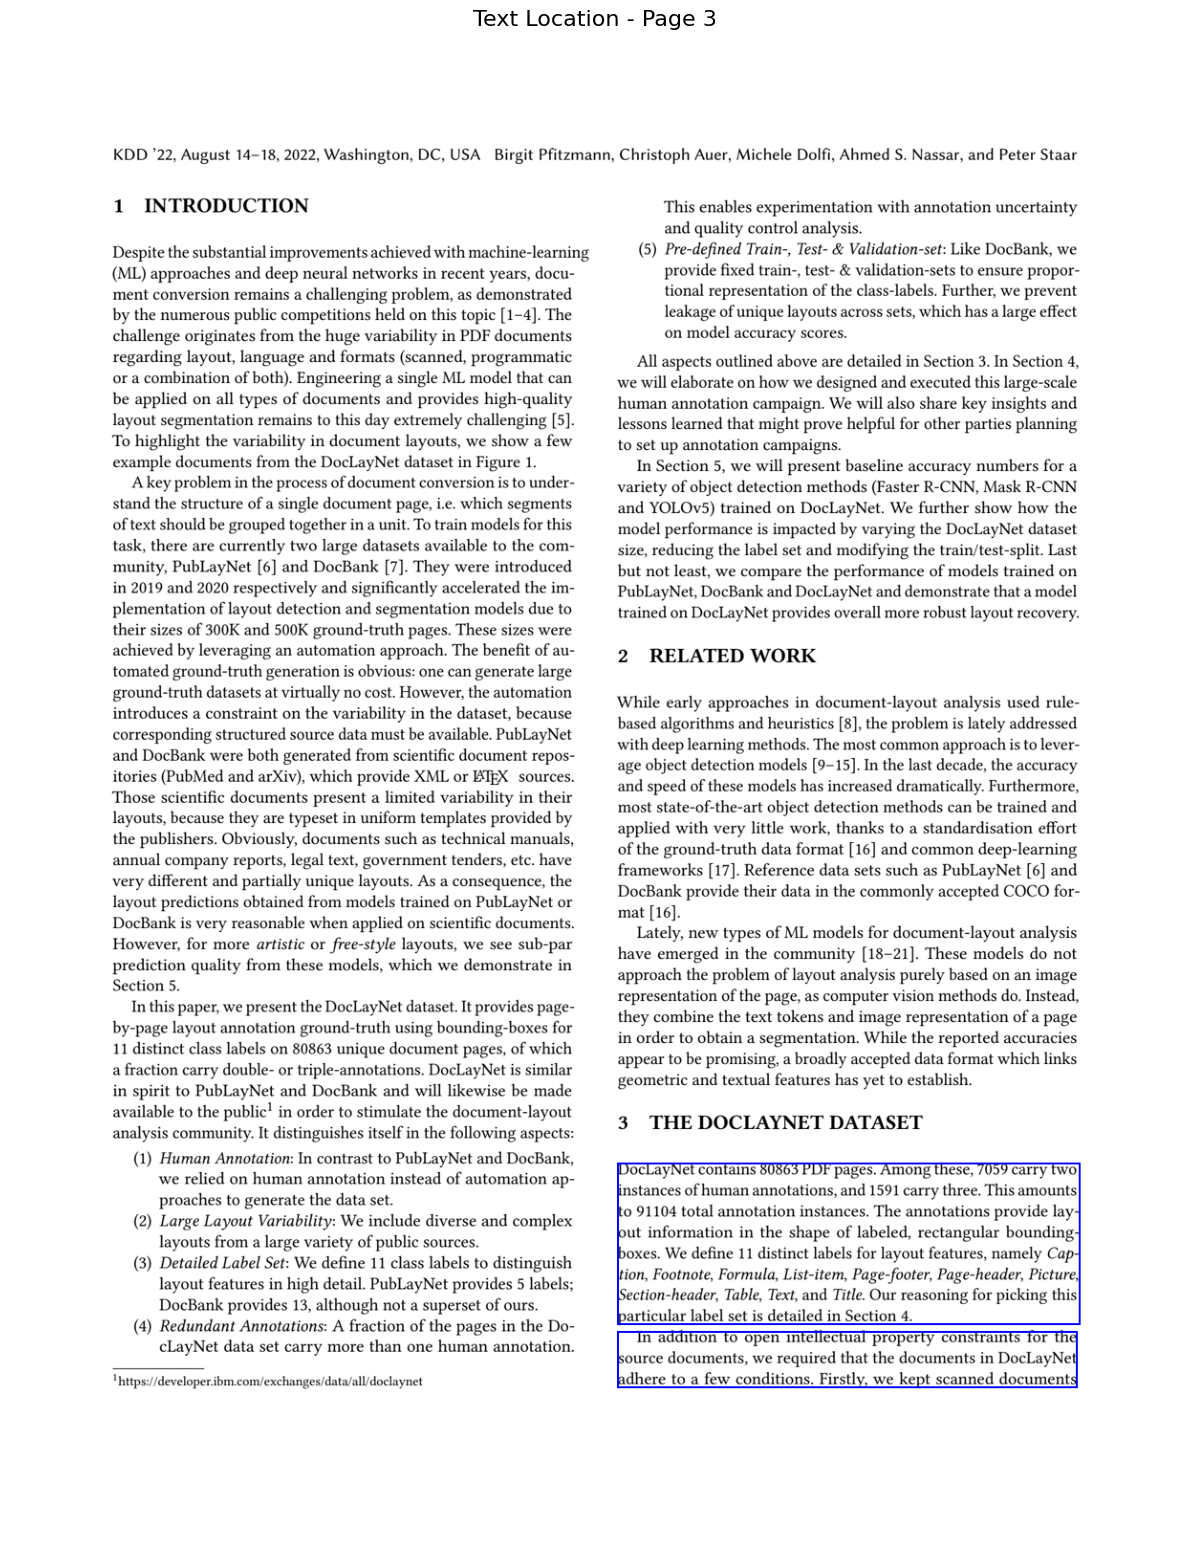

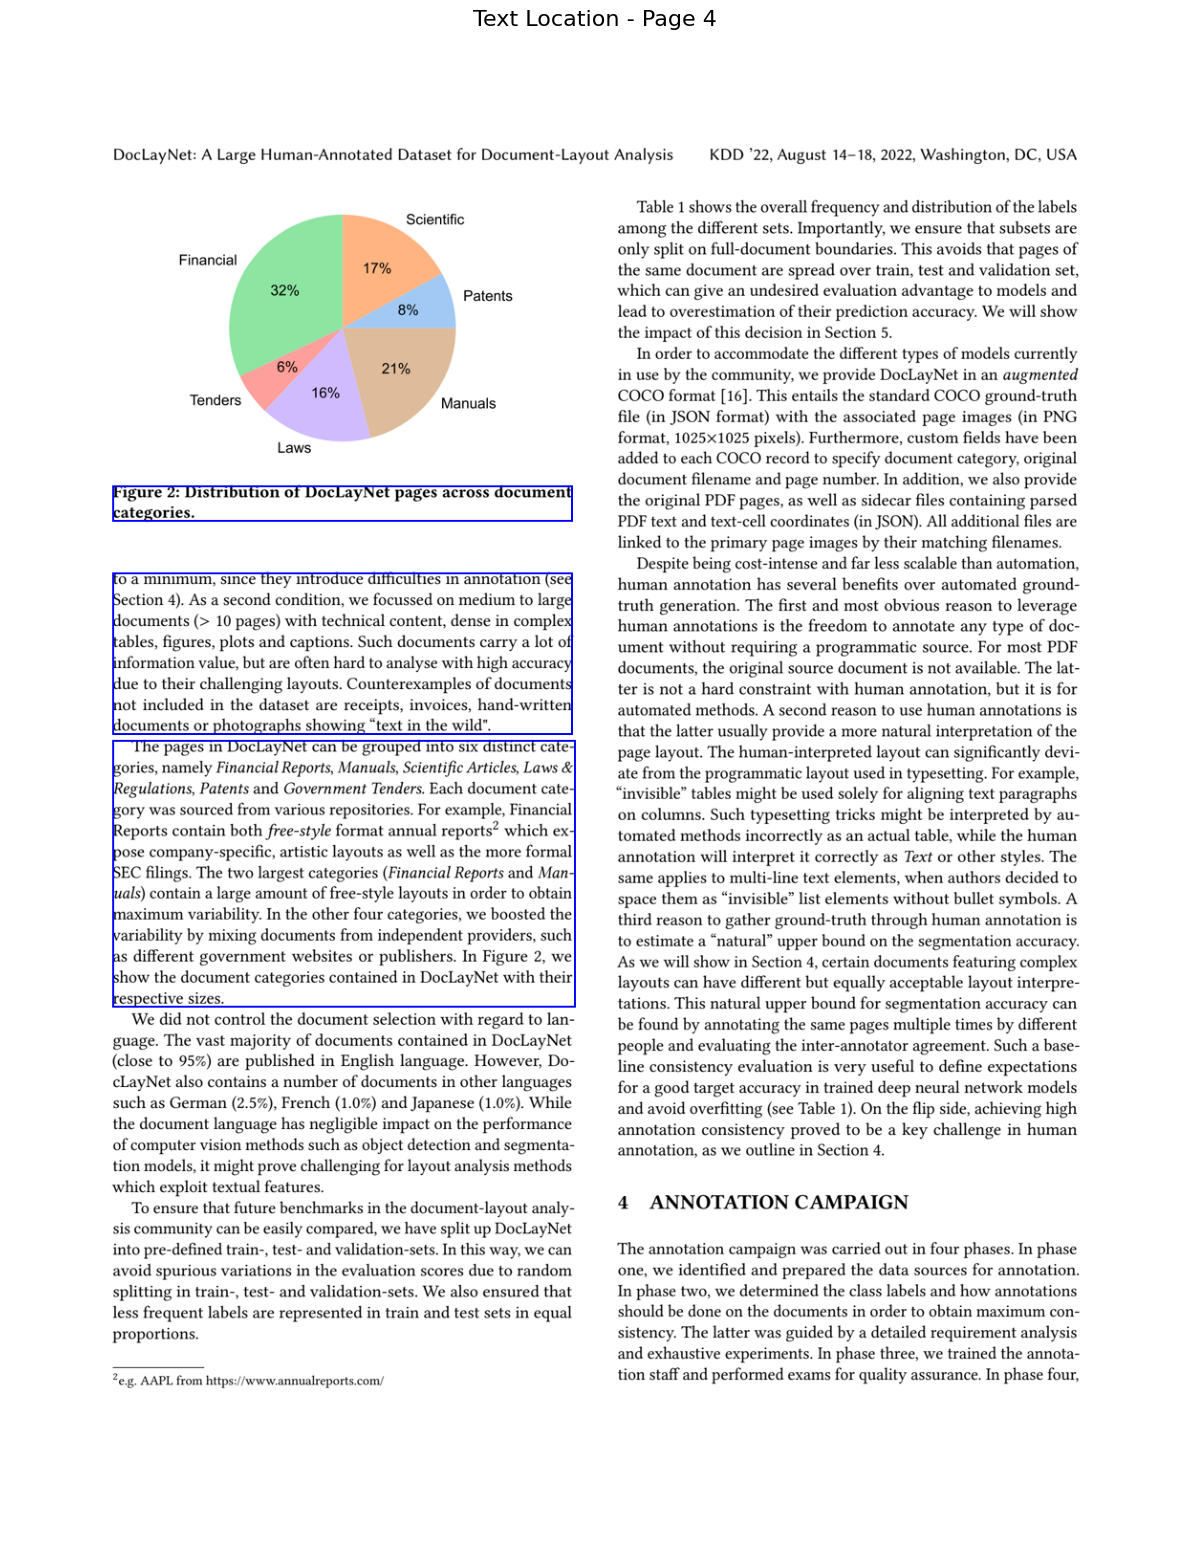


--- Result 2 ---
Content type: Text Chunk
Text preview: 3 THE DOCLAYNET DATASET
We did not control the document selection with regard to language. The vast majority of documents contained in DocLayNet (close to 95%) are published in English language. However, DocLayNet also contains a number of documents in other languages such as German (2.5%), French (1.0%) and Japanese (1.0%). While the document language has negligible impact on the performance of computer vision methods such as object detection and segmentation models, it might prove challenging ...
Source: 2206.01062
Visualizing source location for chunk 12


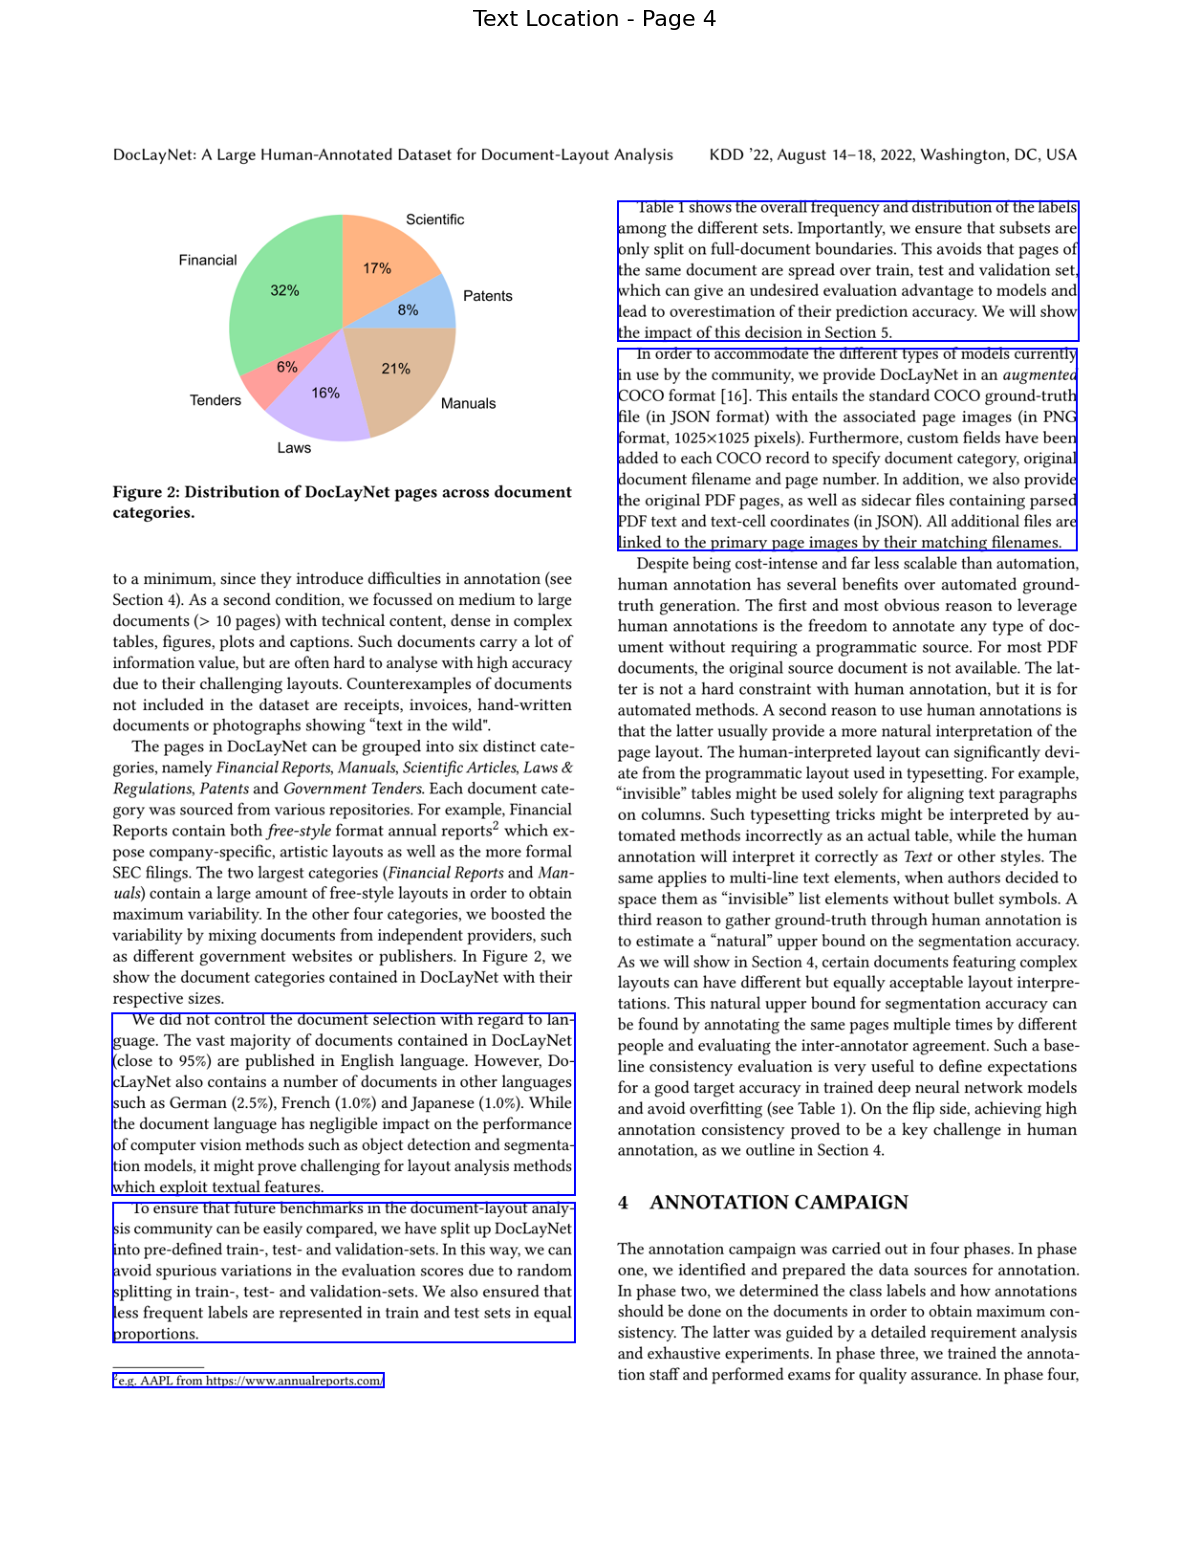

In [36]:
outputs, chunks = rag_with_visual_grounding(
    "How many PDF pages does DocLayNet contain?",
    vector_db,
    doc_store,
    model,
    tokenizer,
    top_k=2,
)

### Multimodal Results


Question: Which are the three main stages of the DocQA pipeline?

Generated Answer:
The three main stages of the DocQA pipeline are Document Conversion, Information Retrieval, and Response Generation <|start_of_cite|>{"document_id": "61"}<|end_of_cite|>. In Document Conversion, an original document is transformed into a machine-readable format through layout analysis and table structure creation. The Information Retrieval stage involves encoding both the document and user queries, followed by semantic search using Natural Language Processing techniques to understand context and meaning. Response Generation, however, is not explicitly detailed in the provided document.

Found 3 relevant chunks:

--- Result 1 ---
Content type: Text Chunk
Text preview: Related Work
The DocQA integrates multiple AI technologies, namely:
Document Conversion: Converting unstructured documents, such as PDF files, into a machine-readable format is a challenging task in AI. Early strategies for document conver

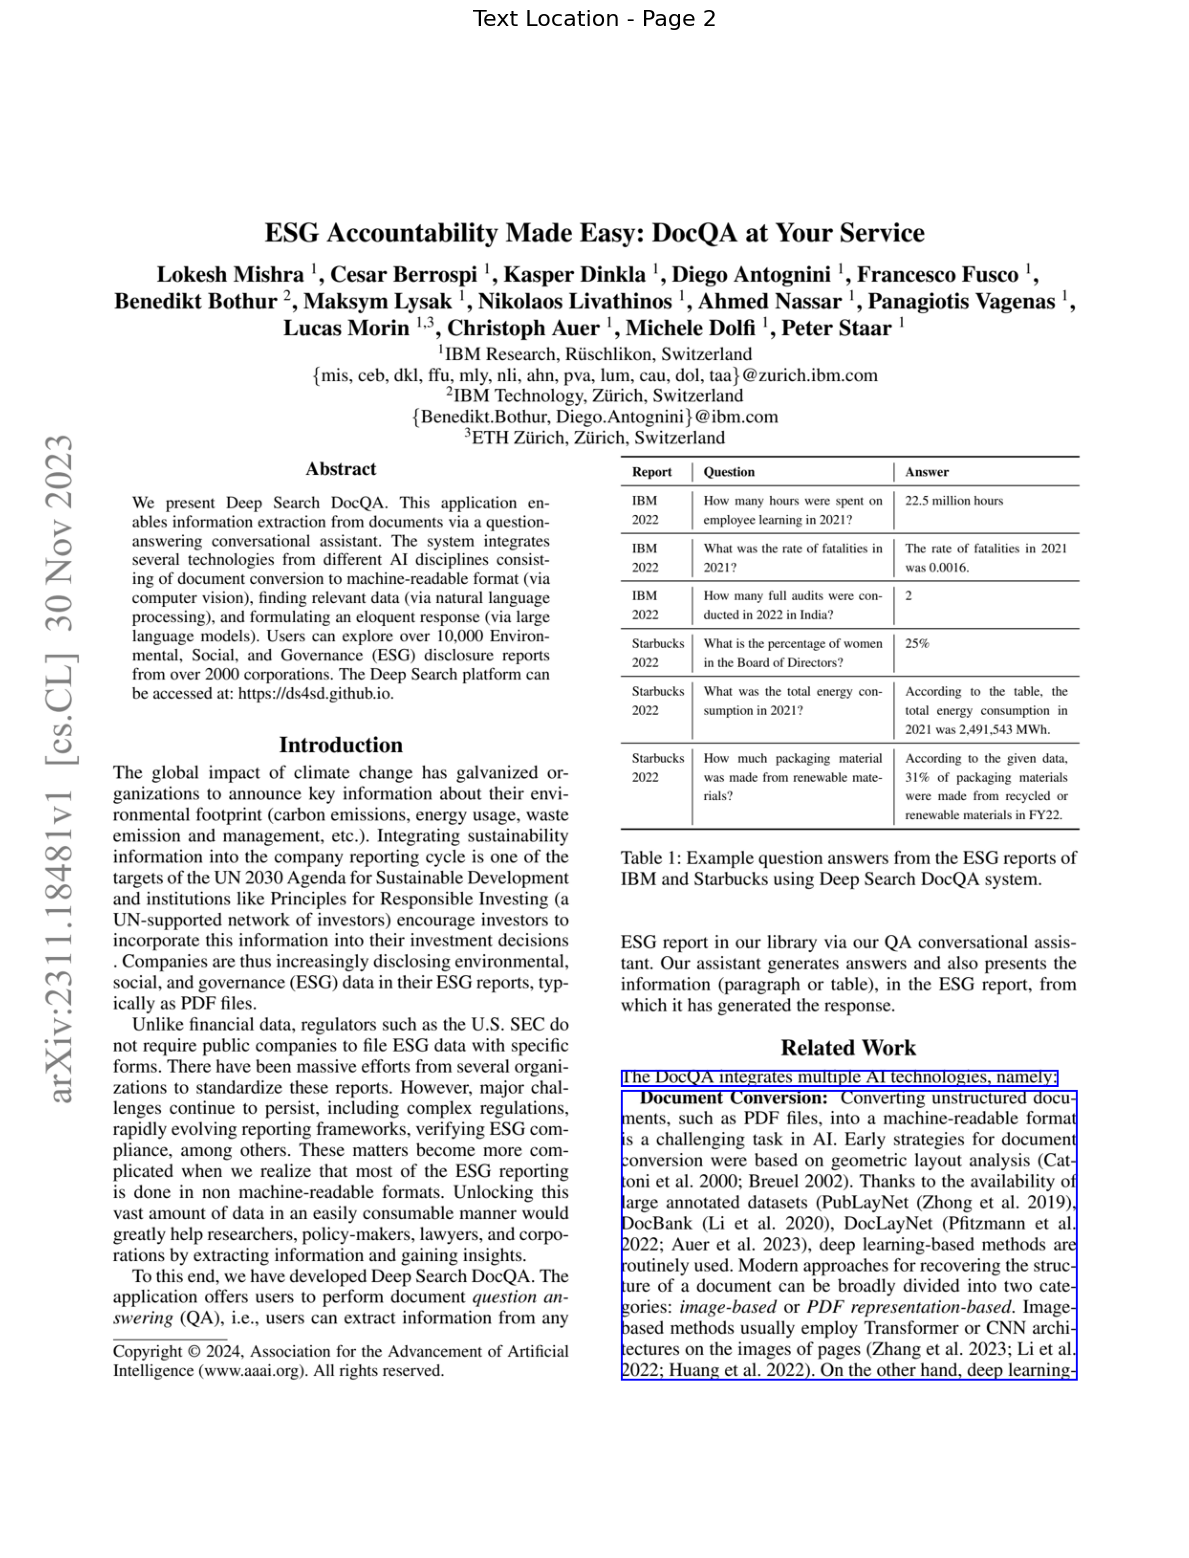

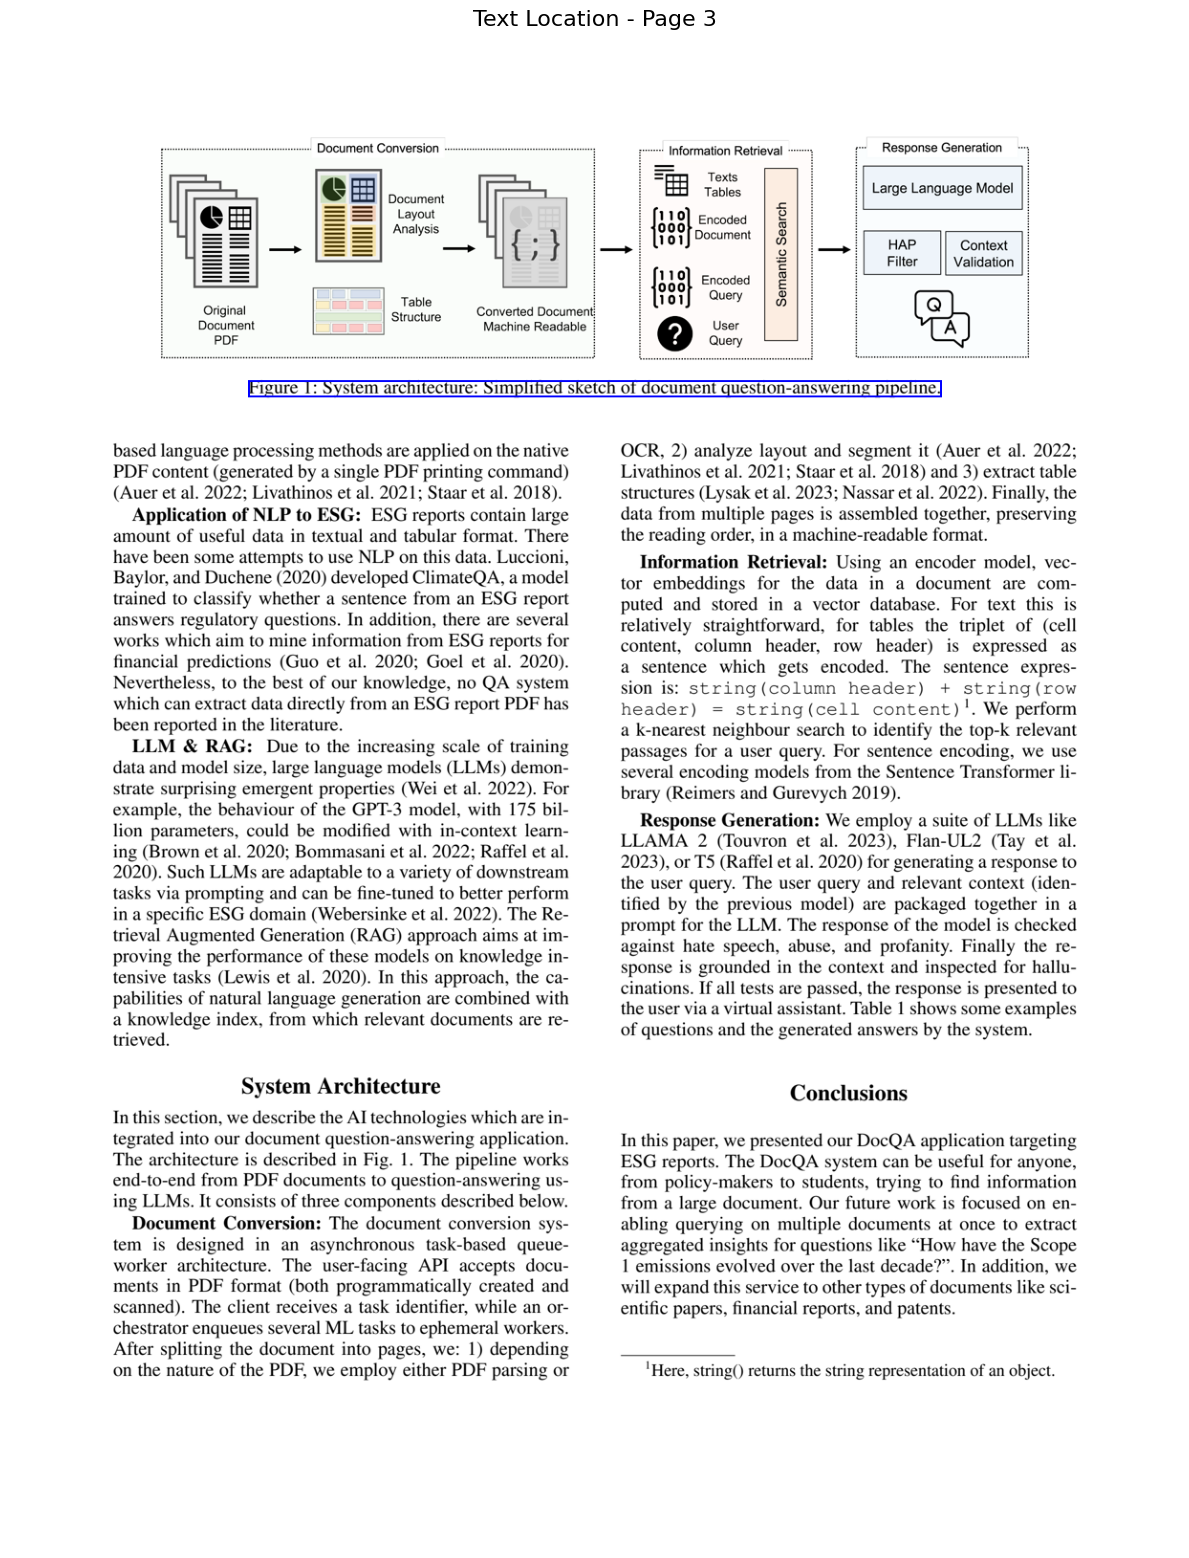


--- Result 2 ---
Content type: Text Chunk
Text preview: Conclusions
In this paper, we presented our DocQA application targeting ESG reports. The DocQA system can be useful for anyone, from policy-makers to students, trying to find information from a large document. Our future work is focused on enabling querying on multiple documents at once to extract aggregated insights for questions like 'How have the Scope 1 emissions evolved over the last decade?'. In addition, we will expand this service to other types of documents like scientific papers, finan...
Source: 2311.18481
Visualizing source location for chunk 65


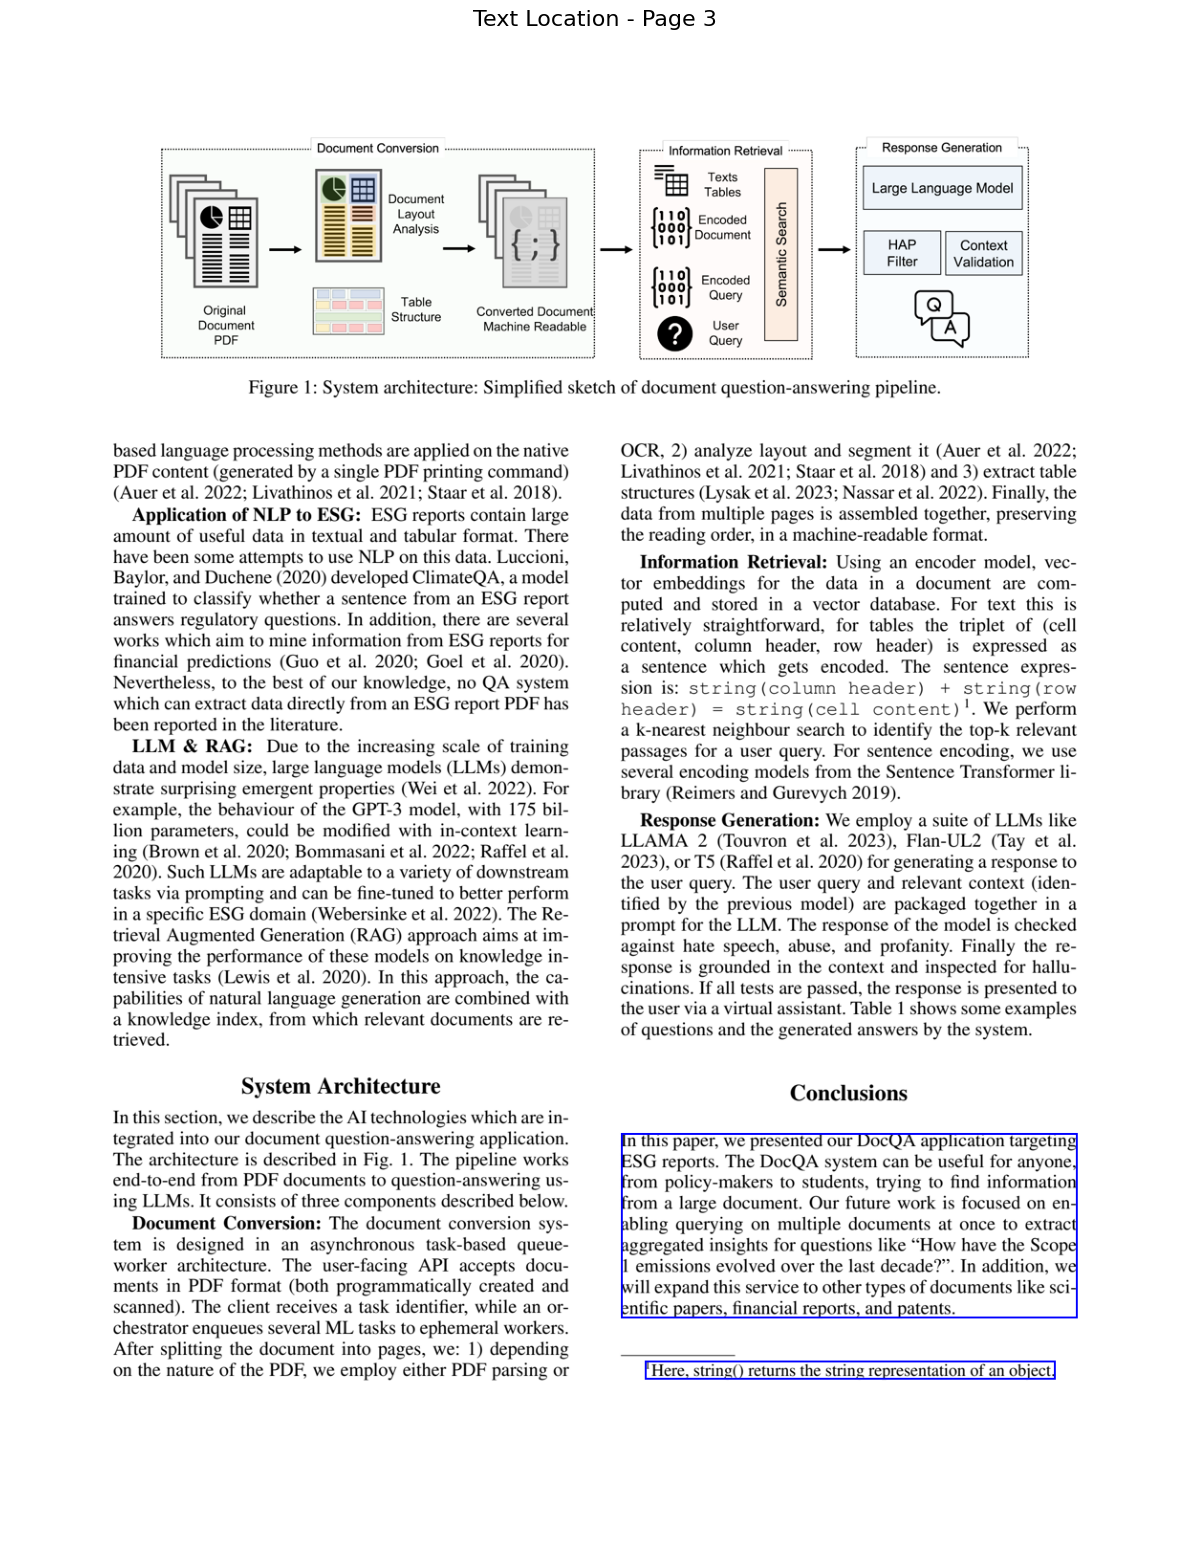


--- Result 3 ---
Content type: AI-Generated Image Description
Text preview: Related Work
Figure 1: System architecture: Simplified sketch of document question-answering pipeline.

The image appears to be a flowchart or diagram outlining a process involving document conversion, information retrieval, and response generation. Here’s a detailed breakdown:

### Document Conversion
1. **Original Document**: The process begins with an original document, which is in PDF format. This could be any type of text-based document.
2. **Document Layout Analysis**: The next step involv...
Source: 2311.18481
Visualizing source location for chunk 61


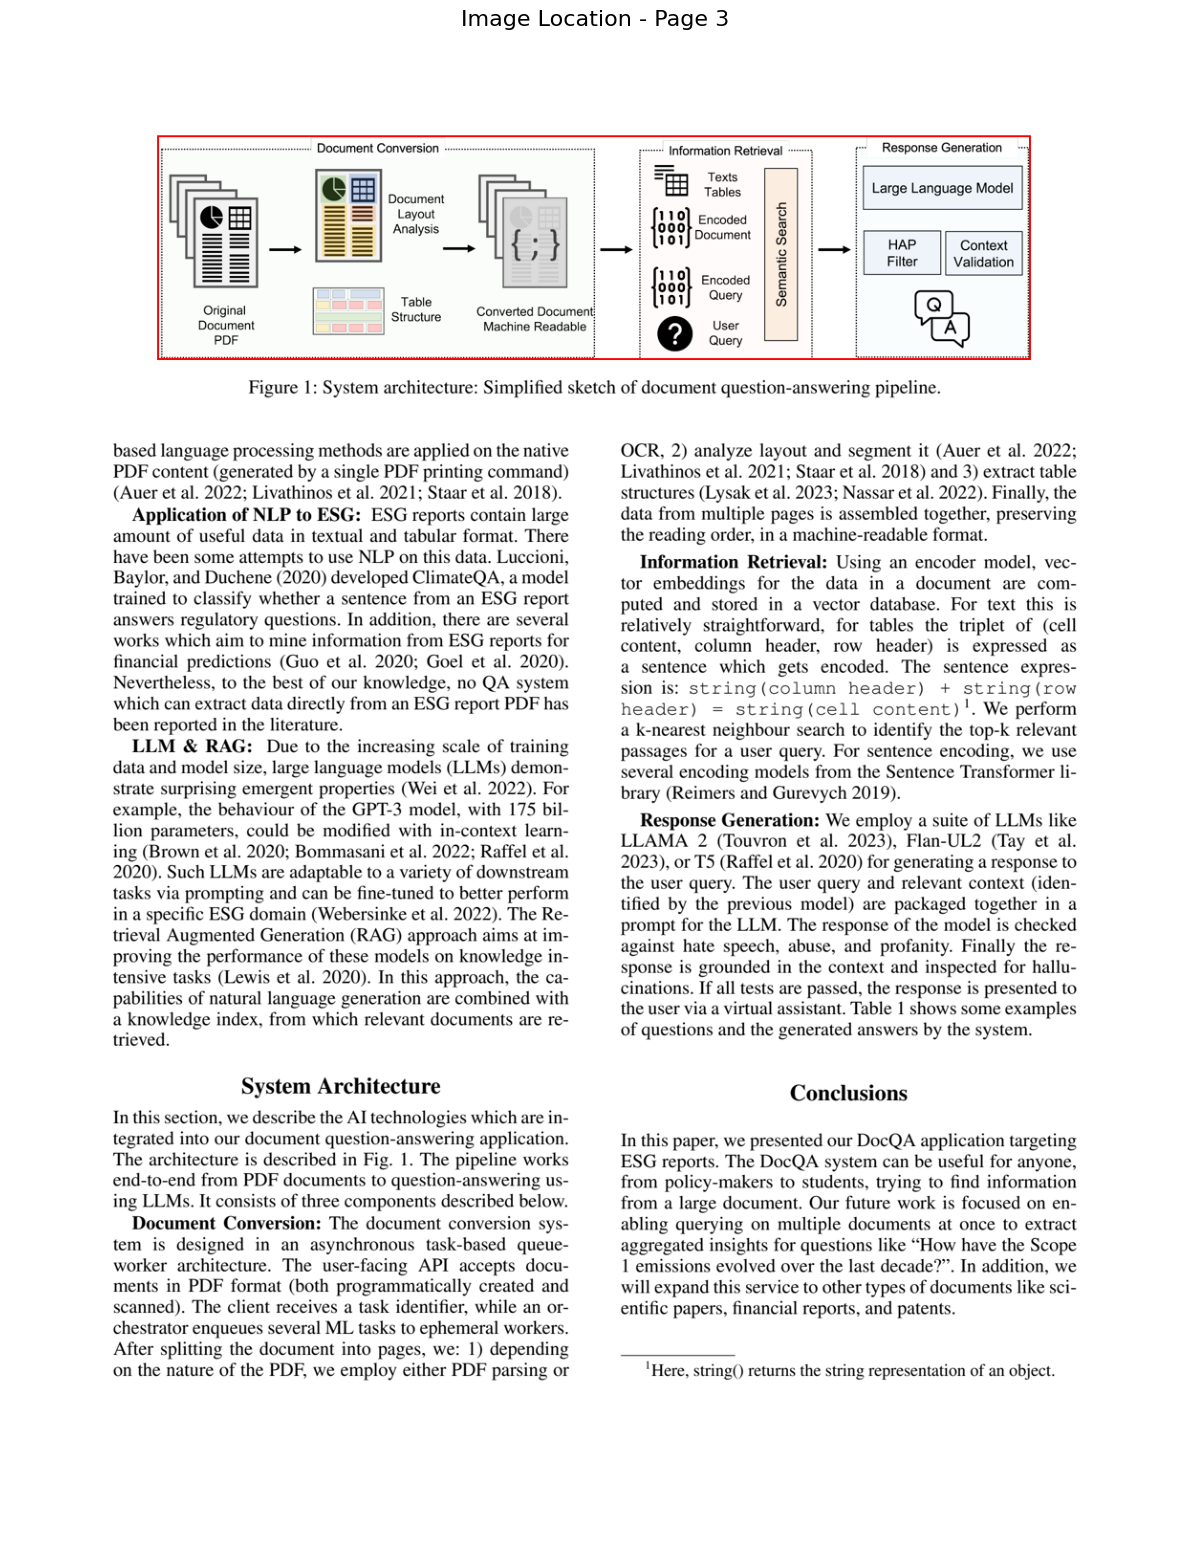

In [37]:
outputs, chunks = rag_with_visual_grounding(
    "Which are the three main stages of the DocQA pipeline?",
    vector_db,
    doc_store,
    model,
    tokenizer,
    top_k=3,
)

# Summary and Next Steps

### What You've Accomplished

Congratulations! You've successfully built an advanced multimodal RAG system with visual grounding. Here's what you've learned:

### Technical Skills Acquired

1. **Visual Grounding Implementation**
   - Configured Docling for visual reference preservation
   - Maintained coordinate metadata through processing pipeline
   - Created visual attribution for all content types

2. **Multimodal Document Processing**
   - Handled text, tables, and images seamlessly
   - Usage of serializers in Docling chunking
   - Used AI vision models for image understanding
   - Preserved structure while enabling search

3. **Transparent RAG Architecture**
   - Built trust through visual verification
   - Enabled source attribution for every response
   - Created differentiated highlighting for content types

4. **Production-Ready Integration**
   - Combined multiple AI models effectively
   - Implemented robust error handling
   - Created scalable document processing pipeline

### Why Visual Grounding Changes Everything

Traditional RAG systems are "black boxes" - users must trust the AI blindly. Your system:
- **Shows sources**: Every claim can be visually verified
- **Builds trust**: Users see exactly where information comes from
- **Enables audit**: Perfect for regulated industries
- **Mitigates hallucinations**: Visual verification catches errors

### The Power of Multimodal Understanding

By processing text, tables, and images, your system:
- Captures complete document information
- Enables richer queries and responses
- Handles real-world document complexity
- Provides comprehensive answers


---

## Next Steps: Where to Go from Here

### Immediate Actions

1. **Experiment with Your Documents**
   - Try documents with complex layouts
   - Test with technical diagrams and charts
   - Process multi-page reports with mixed content

2. **Customize for Your Domain**
   ```python
   # Example: Domain-specific image prompts
   medical_prompt = "Describe this medical image, noting any abnormalities or key features"
   financial_prompt = "Analyze this financial chart, identifying trends and key data points"
   ```

3. **Optimize Performance**
   - Batch process documents
   - Implement caching for visual grounding
   - Use GPU acceleration for vision models

---

## Resources for Continued Learning

### Official Documentation
- **[Docling Documentation](https://github.com/docling-project/docling)**: Latest features and updates
- **[IBM Granite Models](https://www.ibm.com/granite/)**: Model cards and capabilities
- **[LangChain Docs](https://python.langchain.com/)**: RAG patterns and best practices
- **[Milvus Documentation](https://milvus.io/docs)**: Vector database optimization

### Community Resources
- Join the Docling community on GitHub
- Share your implementations
- Contribute improvements back to the project

### Related Topics to Explore
- Document Layout Analysis
- Multimodal Embeddings
- Visual Question Answering
- Explainable AI Systems

---

## Final Thoughts

You've completed an incredible journey from basic document conversion to building a sophisticated, transparent AI system. The combination of Docling's document understanding, Granite's AI capabilities, and visual grounding creates a powerful application.

Your multimodal RAG system with visual grounding represents the cutting edge of document AI. Whether you're building for healthcare, legal, financial, or any other domain, you now have the tools to create AI systems that are not just powerful, but trustworthy and transparent.